# **Tiny ImageNet**

In this notebook we will be building on what has been developed so far, with respect to the Stable Diffusion pipeline. In particular, the focus will be on training a super resolution UNet using the `Tiny ImageNet` dataset. Note that `Fashion MNIST` won't be used here due to its 28x28 image resolution, whereas the ImageNet images are 64x64.

In [1]:
import os, shutil, timm, torch, random, datasets, math
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF, torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode
from glob import glob # unix style pathname pattern expansion

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [2]:
from fastprogress import progress_bar

In [3]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## **Data Processing**

In [4]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'tiny-imagenet-200'

In [5]:
# Note, tiny imagenet isn't widely available, but is still retained by Stanford.
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive('data/tiny-imagenet-200.zip', 'data')

In [6]:
bs = 512

In [12]:
# Simple class to create a dataset 
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        # Pass specification of files to search
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i): 
        # Return a tuple of items and the titles
        return self.files[i], Path(self.files[i]).parent.parent.name

In [9]:
tds = TinyDS(path/'train')
tds[0]

('data/tiny-imagenet-200/train/n04259630/images/n04259630_239.JPEG',
 'n04259630')

Note that the directory is structured as follows: `train/*category code*/images/....JPEG`.

The validation dataset isn't organized into subdirectories which match the training data. Specifically, there is a `val_annotations.txt` file which contains the necessary data for images and their categories. So additional data processing is required on this front.

In [13]:
# Process val_annotations.txt file
path_anno = path/'val'/'val_annotations.txt'
# Create dict using a generator comprehension, split on tab and grab the first two cols
anno = dict(o.split('\t')[:2] for o in path_anno.read_text().splitlines())

In [24]:
print(path_anno.read_text()[:190])

val_0.JPEG	n03444034	0	32	44	62
val_1.JPEG	n04067472	52	55	57	59
val_2.JPEG	n04070727	4	0	60	55
val_3.JPEG	n02808440	3	3	63	63
val_4.JPEG	n02808440	9	27	63	48
val_5.JPEG	n04399382	7	0	59	63



In [30]:
# Create inherited class to handle the validation data's different labelling approach.
# Here the label won't be the parent.parent name - instead, it will be the name of the file.
class TinyValDS(TinyDS):
    def __getitem__(self, i): return self.files[i], anno[os.path.basename(self.files[i])]

In [26]:
vds = TinyValDS(path/'val')

In [28]:
vds[0], len(tds)

(('data/tiny-imagenet-200/val/images/val_7326.JPEG', 'n02099712'), 100000)

In [31]:
# Now we need to create a generic class which can transform any dataset. We can pass the 
# x or y i.e. independent and dependent variables. __init__() defaults to no-operation.
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tmfy=fc.noop): self.ds, self.tfmx, self.tfmy = ds, tfmx, tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x, y = self.ds[i]
        return self.tfmx(x), self.tfmy(y)

In [35]:
# The dataset also provides a wordnet ID file, with 200 cat codes.
# We will change the coding from its original form to an int.
id2str = (path/'wnids.txt').read_text().splitlines()
# Inverted enumeration
str2id = {v:k for k, v in enumerate(id2str)}

In [52]:
from itertools import islice

dict(islice(str2id.items(), 0, 5))

{'n02124075': 0,
 'n04067472': 1,
 'n04540053': 2,
 'n04099969': 3,
 'n07749582': 4}

In [53]:
# Copying over xmean and xstd values of a batch for transformations
xmean, xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [54]:
def tfmx(x):
    img = read_image(x, mode=ImageReadMode.RGB) / 255
    return (img - xmean[:, None, None])/xstd[:, None, None]

In [55]:
def tfmy(y): return tensor(str2id[y])

In [56]:
tfm_tds = TfmDS(tds, tfmx, tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [64]:
xi, yi = tfm_tds[2]
id2str[yi]

'n04259630'

In [62]:
xi.shape

torch.Size([3, 64, 64])

In [59]:
# Denormalize image for viewing 
def denorm(x): return (x*xstd[:, None, None] + xmean[:, None, None]).clip(0,1)

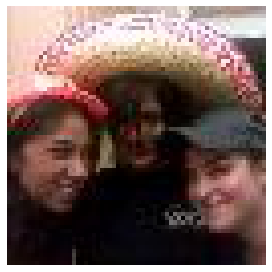

In [65]:
show_image(denorm(xi));

In [72]:
# Create dataloader for the training set.
dltrn = DataLoader(tfm_tds, batch_size=bs, shuffle=True, num_workers=8)

In [73]:
xb, yb = b = next(iter(dltrn))

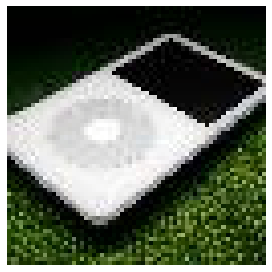

In [74]:
show_image(denorm(xb[0]));

Now that we have enumerated the wordnet categories, we can use the additional `words.txt` file to grab titles for the keys for each image category. This is a large file with many additional codes, so the title grabbing will need to be selective.

In [76]:
# This wordnet encoding schema is called `synsets`
all_synsets = [o.split('\t') for o in (path/'words.txt').read_text().splitlines()]
all_synsets[:20]

[['n00001740', 'entity'],
 ['n00001930', 'physical entity'],
 ['n00002137', 'abstraction, abstract entity'],
 ['n00002452', 'thing'],
 ['n00002684', 'object, physical object'],
 ['n00003553', 'whole, unit'],
 ['n00003993', 'congener'],
 ['n00004258', 'living thing, animate thing'],
 ['n00004475', 'organism, being'],
 ['n00005787', 'benthos'],
 ['n00005930', 'dwarf'],
 ['n00006024', 'heterotroph'],
 ['n00006150', 'parent'],
 ['n00006269', 'life'],
 ['n00006400', 'biont'],
 ['n00006484', 'cell'],
 ['n00007347', 'causal agent, cause, causal agency'],
 ['n00007846', 'person, individual, someone, somebody, mortal, soul'],
 ['n00015388', 'animal, animate being, beast, brute, creature, fauna'],
 ['n00017222', 'plant, flora, plant life']]

In [77]:
# Filter to synsets which occur in our training data
synsets = {k:v.split(',', maxsplit=1)[0] for k, v in all_synsets if k in id2str}
# Extract titles
titles = [synsets[id2str[o]] for o in yb]
', '.join(titles[:20])

'iPod, jellyfish, fur coat, frying pan, kimono, guacamole, coral reef, lifeboat, poncho, sea cucumber, bikini, tailed frog, dugong, banana, lesser panda, magnetic compass, iPod, Egyptian cat, triumphal arch, sports car'

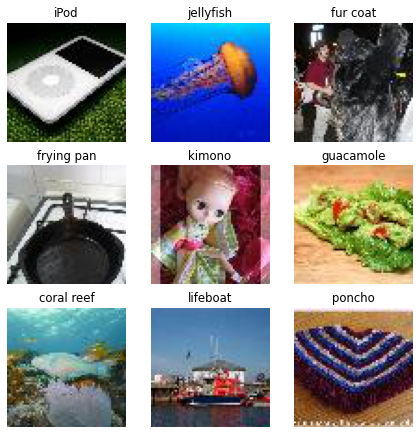

In [78]:
show_images(denorm(xb[:9]), titles=titles[:9], imsize=2.5)

In [80]:
# Load transformed and labelled data onto DataLoader
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

## **Train Basic Model**

In [82]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop): return tfm_x(b[0]), tfm_y(b[1])

In [83]:
tfms = nn.Sequential(T.Pad(4), T.RandomCrop(64),
                     T.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [85]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [86]:
nfs = (32, 64, 128, 256, 512, 1024)

In [87]:
def get_dropmodel(act=act_gr, nfs=nfs, norm=nn.BatchNorm2d, drop=0.1):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


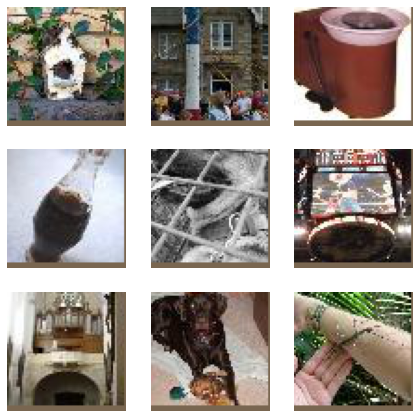

In [88]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), augcb, DeviceCB()])
learn.fit(1)
xb, yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [89]:
learn.summary()

Tot params: 19775824; MFLOPS: 303.7


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Conv2d|(512, 3, 64, 64)|(512, 32, 64, 64)|2432|9.8|
|ResBlock|(512, 32, 64, 64)|(512, 64, 32, 32)|57792|58.7|
|ResBlock|(512, 64, 32, 32)|(512, 128, 16, 16)|230272|58.7|
|ResBlock|(512, 128, 16, 16)|(512, 256, 8, 8)|919296|58.7|
|ResBlock|(512, 256, 8, 8)|(512, 512, 4, 4)|3673600|58.7|
|ResBlock|(512, 512, 4, 4)|(512, 1024, 2, 2)|14687232|58.7|
|AdaptiveAvgPool2d|(512, 1024, 2, 2)|(512, 1024, 1, 1)|0|0.0|
|Flatten|(512, 1024, 1, 1)|(512, 1024)|0|0.0|
|Dropout|(512, 1024)|(512, 1024)|0|0.0|
|Linear|(512, 1024)|(512, 200)|204800|0.2|
|BatchNorm1d|(512, 200)|(512, 200)|400|0.0|
